# Исследование прогноза оттока клиентов.

## Описание проекта.

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Описание полей данных

- BeignDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами
- Type - тип оплаты: ежемесячный, годовой и тд
- PaperlessBilling - электронный платежный документ
- PaymentMethod - способ оплаты
- MontlyCharges - ежемесячные траты на услуги
- TotalChatges - всего потрачено денег на услуги
- Dependents - наличие иждивенцев
- SeniorCitizen - наличие пенсионного статуса по возрасту
- Partner - наличие супруга(и)
- MultipleLines - наличие возможности ведения параллельных линий во время звонка

**ЗАДАЧА ПРОЕКТА** - Построить модель для прогноза оттока клиентов.

### План работы

1. Изучение данных и постановка задачи. Предварительное знакомство с данными, первичный анализ.


2. Исследовательский анализ и предобработка данных. Подготовка данных к дальнейшему исследованию - работа с пропусками, дубликатами и аномальными значениями. Визуализация и поиск зависимостей.


3. Обучение моделей. Разделение датасета на выборки, кодирование признаков, выбор моделей и методов, необходимых для исследования, подбор гиперпараметров.


4. Тестирование финальной модели. Проанализировать эффективность модели, составить заключение.


5. Отчет о проделанной работе.

## Анализ данных

### Изучение данных

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 80523

In [ ]:
contract_df = pd.read_csv('/datasets/contract_new.csv')
personal_df = pd.read_csv('/datasets/personal_new.csv')
internet_df = pd.read_csv('/datasets/internet_new.csv')
phone_df = pd.read_csv('/datasets/phone_new.csv')

In [ ]:
def df_research(data):
    display(data.head())
    print(data.info(), '\nКоличество дубликатов:', data.duplicated().sum())
    display(data.describe())
    print('Количество пропусков:\n', data.isna().sum())

In [ ]:
df_research(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 
Количество дубликатов: 0


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество пропусков:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


1. Пропуски и дубликаты отсутствуют
2. Столбцы BeginData и TotalChanges необходимо привести к соответсвтующим типам данных - datetime и float
3. Название параметров привести к змеиному регистру
4. EndDate является целевым признаком и его значения небходимо трансформировать в 0 - "No", 1 - дата ухода клиента. Но в то же время этот параметр показывает, как долго клиент пользуется услугами, что важно для прогноза. В таком случае, создадим дополнительный параметр.

In [ ]:
print('Первая дата датасета:', min(contract_df['BeginDate']))
print('Последняя дата датасета:', max(contract_df['BeginDate']))

Первая дата датасета: 2013-10-01
Последняя дата датасета: 2020-02-01


In [ ]:
contract_df['BeginDate'].sort_values().unique()

array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

Можно заметить, что подключение клиентов происходит первого числа каждого месяца от начала датасета.

In [ ]:
contract_df['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-10-01       1
2014-11-01       1
2014-06-01       1
Name: EndDate, Length: 67, dtype: int64

In [ ]:
len(contract_df[contract_df['EndDate'] == 'No']) / len(contract_df['EndDate'])

0.8436745704955275

84% пользователей продолжают пользоваться услугами компании. Заметен дисбаланс классов.

In [ ]:
contract_df['TotalCharges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

In [ ]:
contract_df[contract_df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Все пропущенные значения совпадают с последней датой в таблице. Вероятно, это новые клиенты, которые еще не заплатили за услуги. Целесообразно будет заменить пропуски на нулевые значения, либо удалить.

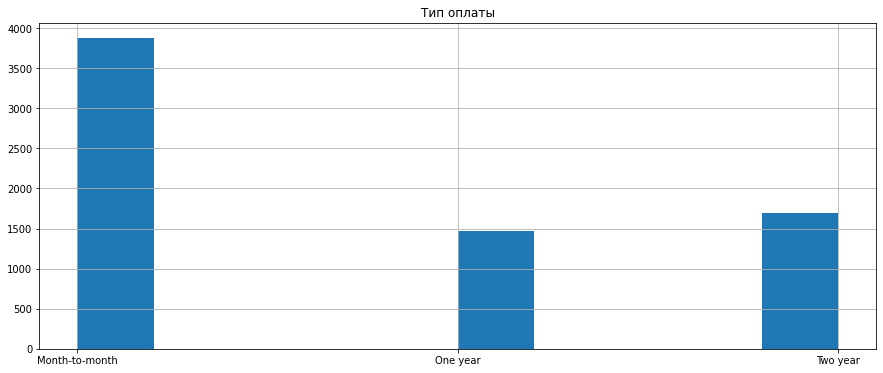

In [ ]:
contract_df['Type'].hist(figsize=(15, 6), grid=True)
plt.title('Тип оплаты');

Наиболее популярный тип оплаты - ежемесячный

In [ ]:
contract_df['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

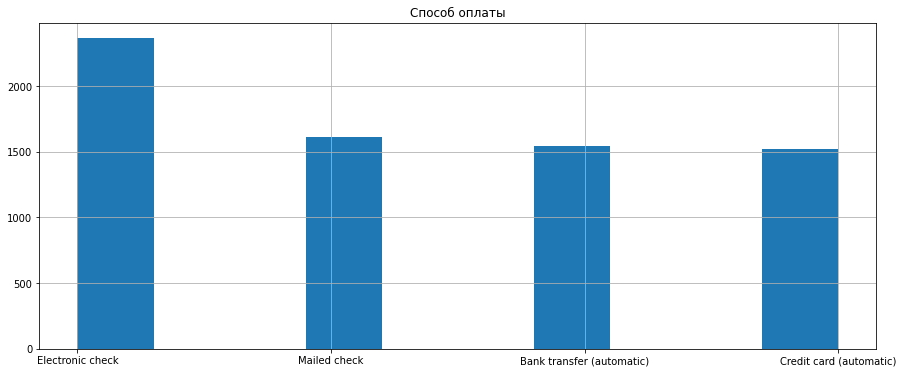

In [ ]:
contract_df['PaymentMethod'].hist(figsize=(15, 6), grid=True)
plt.title('Способ оплаты');

Элетронный тип оплаты пользуется наибольшим спросом

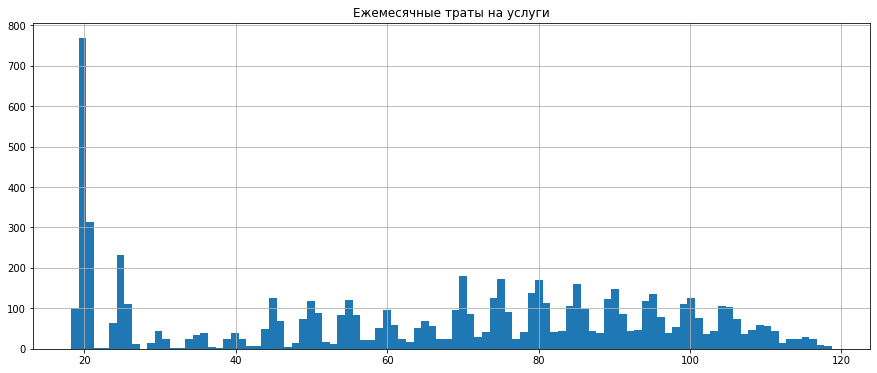

In [ ]:
contract_df['MonthlyCharges'].hist(bins=100, figsize=(15, 6), grid=True)
plt.title('Ежемесячные траты на услуги');

Наибольшее количество людей, вероятно, пользуются отдной услугой, стоимость которой чуть меньше 20у.е. В остальном распределение равномерное.

In [ ]:
df_research(personal_df)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None 
Количество дубликатов: 0


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество пропусков:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


1. Количество строк в датасете совпадает с таблицей contract
2. Пропусков и дубликатов не обнаружено
3. Таблица имеет признаки с бинарной классификацией, необходимо задать для них подходящий формат - 1 и 0
4. Привести таблицу к змеиному регистру

In [ ]:
personal_df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

По гендерному распределению - почти равенство

In [ ]:
personal_df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Людей пенсионного возраста значительно меньше, чем людей, не имеющий данный статус

In [ ]:
personal_df['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Одиноких людей немного больше, чем замужних.

In [ ]:
df_research(internet_df)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None 
Количество дубликатов: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5365-LLFYV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество пропусков:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


1. Строк в датасете меньше, чем в таблицах contract и personal, соответственно, некоторые люди пользуются исключительно услугами, связанные с интернетом
2. Пропусков и дубликатов не обнаужено
3. Все признаки имеют бинарную классификацию
4. Люди чаще выбирают оптоволокно и, как правило, отказываются от дополнительных услуг

In [ ]:
df_research(phone_df)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None 
Количество дубликатов: 0


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8510-BBWMU,No
freq,1,3390


Количество пропусков:
 customerID       0
MultipleLines    0
dtype: int64


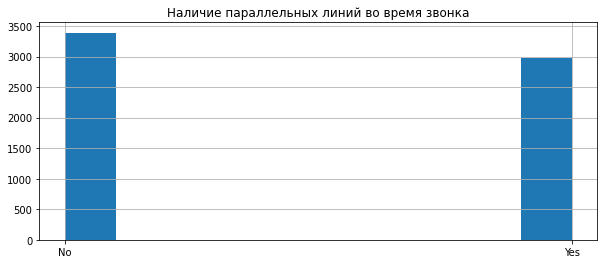

In [ ]:
phone_df['MultipleLines'].hist(figsize=(10,4))
plt.title('Наличие параллельных линий во время звонка');

1. Как и в предыдущем датасете, данных содержится меньше, чем в conract и personal. После объединения таблиц логично будет пропущенные зачения заменить на 'No'.
2. Пропуски и дубликаты отсутсвуют
3. Необходимо изменить регистр
4. У большинства пользователей отсутствует данная функция

### Предобработка данных

Для начала объединим таблицы по столбцу с id пользователя. Этот же столбец мы будем использовать в качестве индекса.

In [ ]:
df = contract_df.merge(personal_df, on='customerID', how='left')
df = df.merge(internet_df, on='customerID', how='left')
df = df.merge(phone_df, on='customerID', how='left')

In [ ]:
df = df.set_index('customerID')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

Изменим стиль написания признаков на более корректный snake_case.

In [ ]:
df.columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
              'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
              'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies', 'multiple_lines']

После объединения таблиц появились пропуски. Используем заглушку, отличную от 'No', в данных о парралельных линиях во время звонка, так как клиент может пользоваться исключительно этой услугой, а к общей телефонии он не подключен.

В остальных случаях корректно будет сделать замену именно на 'No', поскольку отсутствие данных в датасете означает и отсутствие услуги.

In [ ]:
df['multiple_lines'] = df['multiple_lines'].fillna('Mlines')

In [ ]:
for column in ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
          'streaming_movies']:
    df[column] = df[column].fillna('No')

Бинарные признаки, разделение которых происходит на 'Yes' и 'No', трансформируем в '1' и '0' соответственно.

In [ ]:
binary_list = ['paperless_billing', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup',
          'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for c in binary_list:
    df[c].replace('Yes', 1, inplace=True)
    df[c].replace('No', 0, inplace=True)

Создадим целевой признак target из колонки end date. 0 будет обозначать, что клиент все еще пользуется услугами, 1 - клиент нас покинул.

In [ ]:
def client_lost(status):
    if status == 'No':
        return 0
    else:
        return 1

df['target'] = df['end_date'].apply(client_lost)

Поменям формат данных в признаках с датами на корректный datetime, чтобы с помощью них создать новый признак, в котором будет храниться информация о количестве дней пользования услугами каждого пользователя. За крайнюю дату возьмем дату выгрузки данных.

Затем, begin_date и end_date можно будет удалить, для дальнейшего исследования они бесполезны.

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

df['days'] = (df['end_date'] - df['begin_date']).dt.days

In [ ]:
df = df.drop(columns = ['begin_date', 'end_date'])

В ходе знакомства с даными было обнаружено наличие пустых строк в столбце total_charges в количестве 11 экземляров, их дата соответствовала дате выгрузки датасета, из чего можно сделать вывод, что это новые клиенты, не успевшие провести первую транзакцию. На исследование эти данные никак не повлияют - удалим их и приведем столбец к корректному формату float.

In [ ]:
df.drop(df[df['total_charges'] == ' '].index, axis=0, inplace=True)
df['total_charges'] = df['total_charges'].astype('float')

In [ ]:
df_research(df)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,days
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,31.04,Female,0,1,0,DSL,0,1,0,0,0,0,Mlines,0,31
5575-GNVDE,One year,0,Mailed check,56.95,2071.84,Male,0,0,0,DSL,1,0,1,0,0,0,No,0,1036
3668-QPYBK,Month-to-month,1,Mailed check,53.85,226.17,Male,0,0,0,DSL,1,1,0,0,0,0,No,0,123
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1960.60,Male,0,0,0,DSL,1,0,1,1,0,0,Mlines,0,1371
9237-HQITU,Month-to-month,1,Electronic check,70.70,353.50,Female,0,0,0,Fiber optic,0,0,0,0,0,0,No,0,153


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   int64  
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   int64  
 8   dependents         7032 non-null   int64  
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   int64  
 11  online_backup      7032 non-null   int64  
 12  device_protection  7032 non-null   int64  
 13  tech_support       7032 non-null   int64  
 14  streaming_tv       7032 non-null   int64  
 15  streaming_movies   7032 non-null   int64  
 16  multiple_lines

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,days
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.592719,64.798208,2118.621822,0.162400,0.482509,0.298493,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.156570,899.961320
std,0.491363,30.085974,2112.736199,0.368844,0.499729,0.457629,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.363421,682.738777
min,0.000000,18.250000,19.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000
25%,0.000000,35.587500,439.745000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,276.000000
50%,1.000000,70.350000,1345.275000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,761.000000
75%,1.000000,89.862500,3239.317500,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1461.000000
max,1.000000,118.750000,9221.380000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2314.000000


Количество пропусков:
 type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
target               0
days                 0
dtype: int64


После индексирования по id клиента появились 4 дубликата, делать с ними ничего не нужно, так как в изначальном датасете дубликатов обнаружено не было.

В ходе предобработки было выполнено:
1. Создание единого датасета
2. Выявлен целевой признак
3. Данные приведены к корректному формату
4. Добавленый новый и удалены лишние признаки

### Исследовательский анализ

Рассмотим распределение категориальных признаков в зависимости от целевого признака

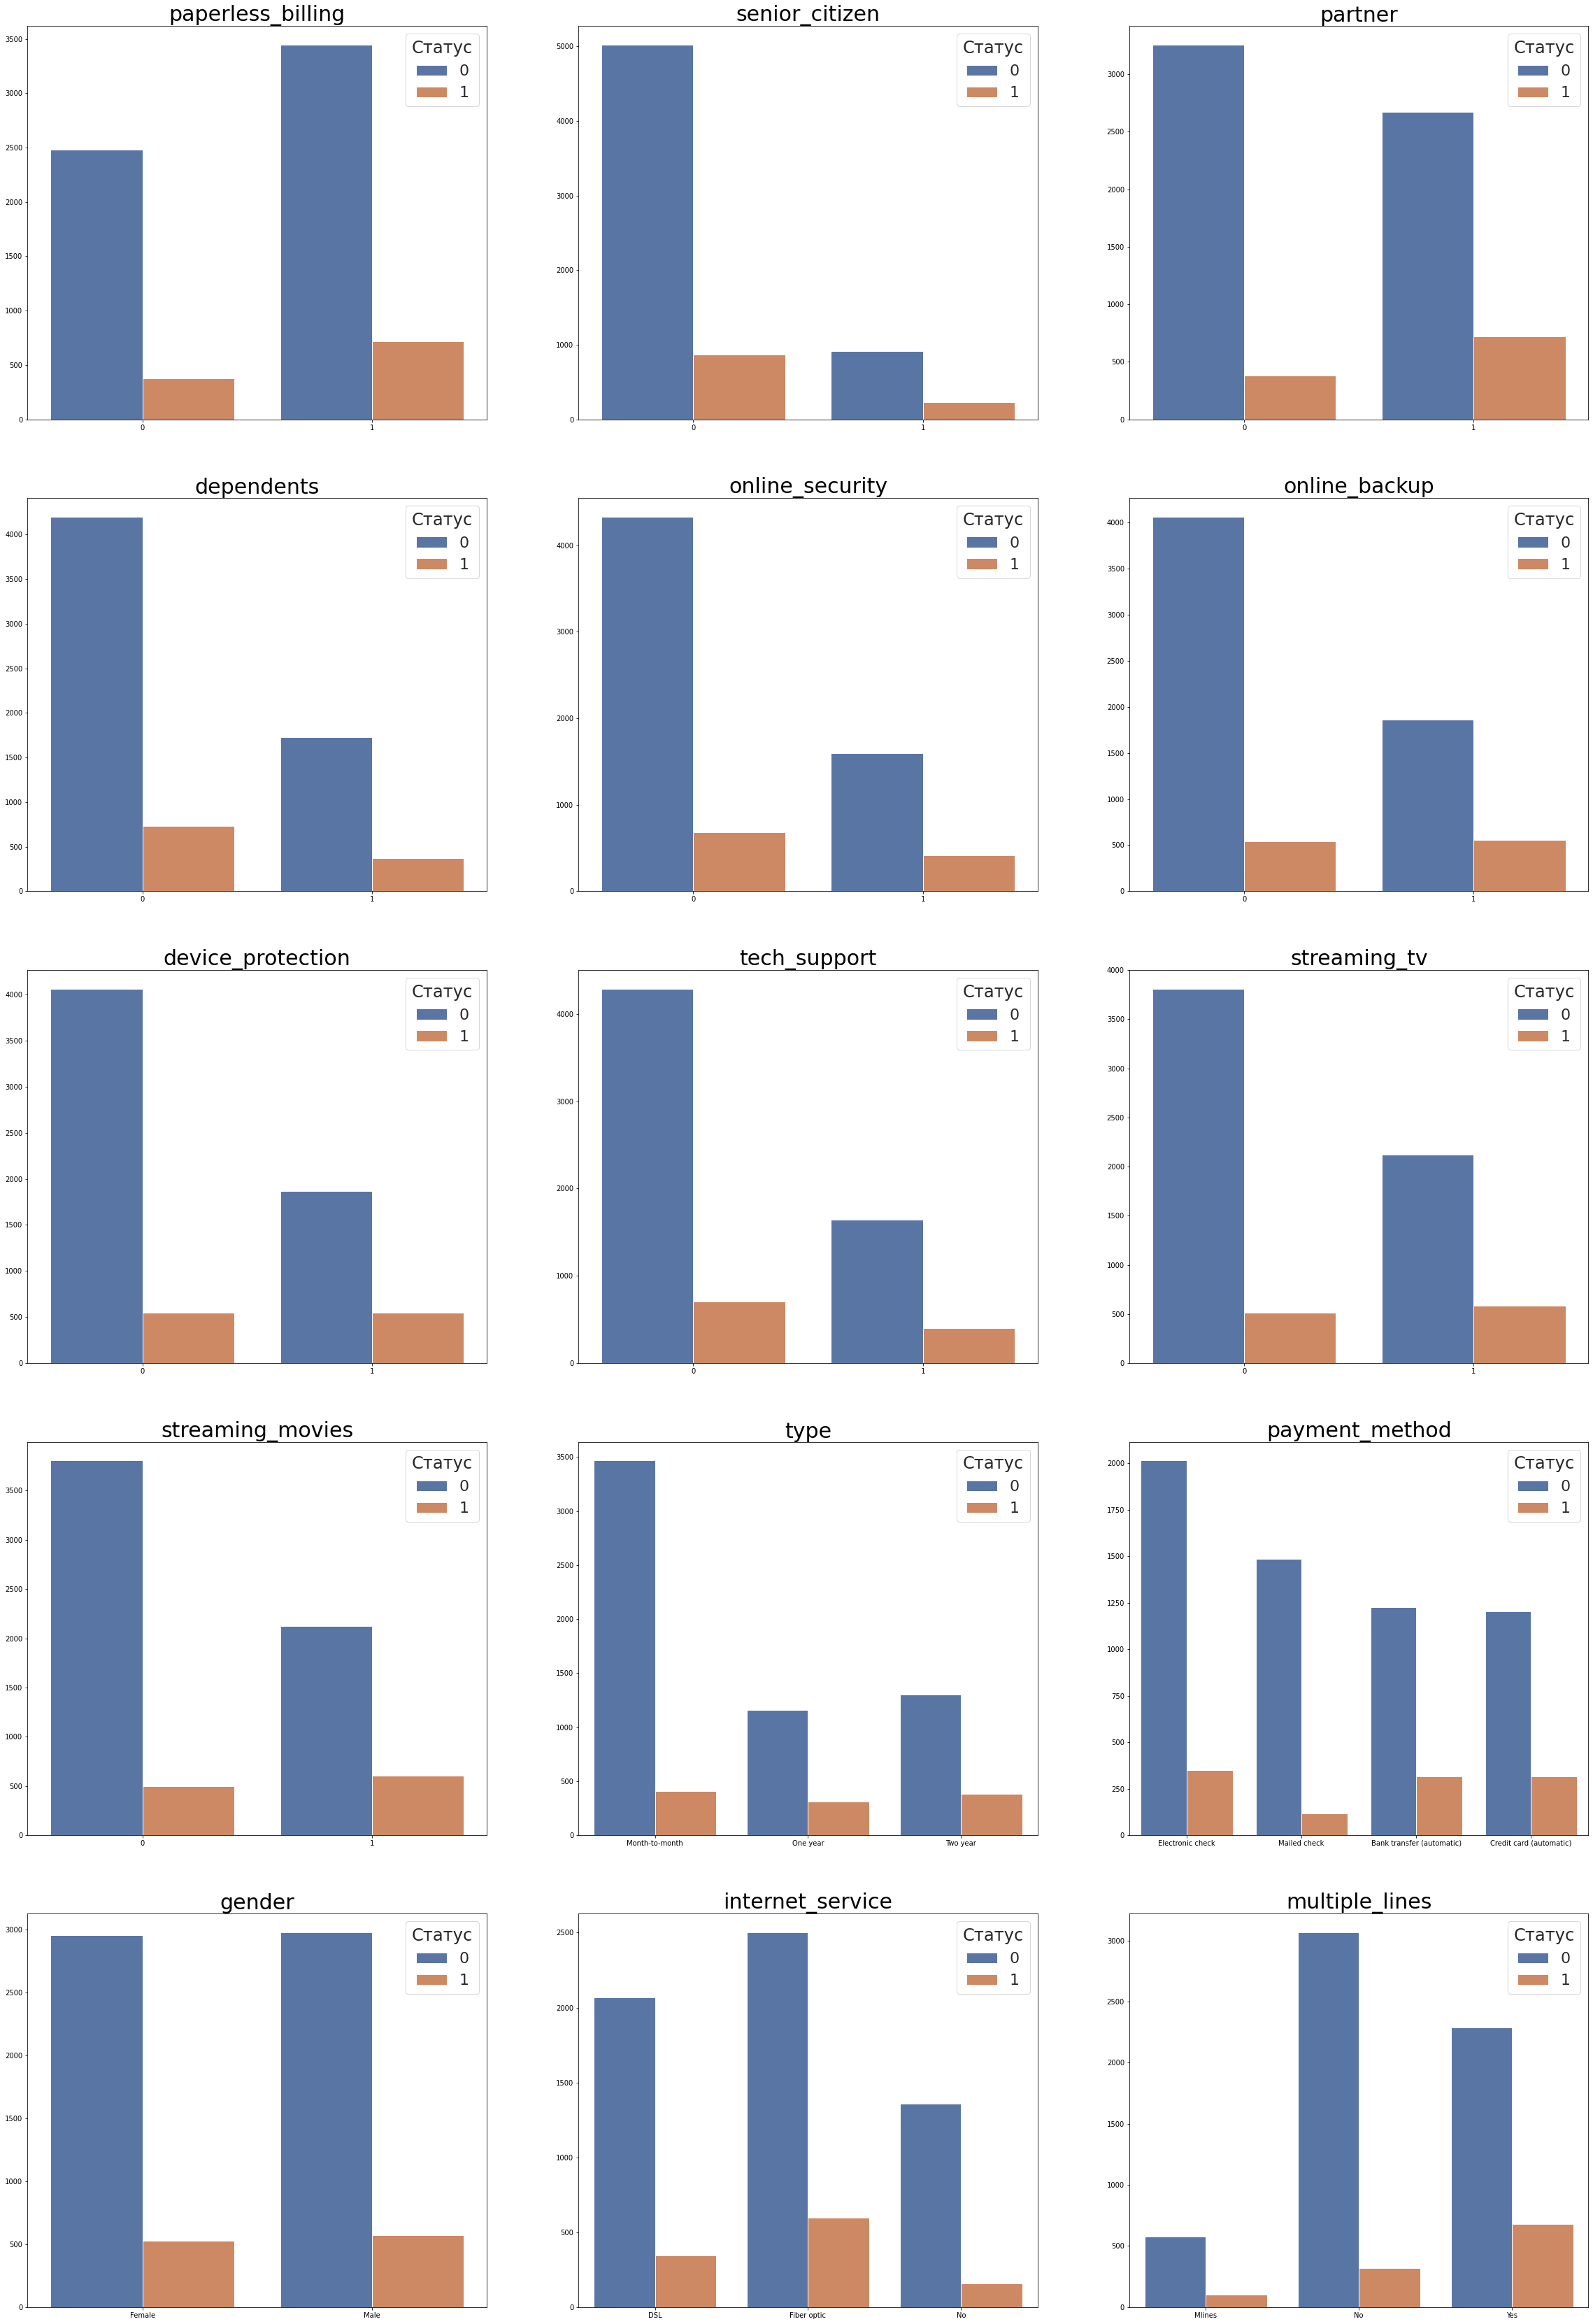

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(40, 60))
sns.set(style='whitegrid', color_codes=True, font_scale=2)

for x, ax in zip(binary_list+['type', 'payment_method', 'gender', 'internet_service', 'multiple_lines'], axes.flat):
    sns.countplot(x=x, data=df, hue='target', ax=ax).set_title(x, size=30)
    ax.legend(title='Статус')
plt.setp(axes, xlabel='', ylabel='')
plt.show()

1. Замужние люди немного чаще перестают быть клиентами компании.
2. Люди пенсионного врозраста представляют меньшенство клиентов. Доля ушедших пенсионеров к активным выше, чем у других пользователей.
3. Среди тех кто пользуется услугами антивируса, облачного хранилища, стримингового телевидения и, особенно, каталога фильмов, высокая доля ушедших к активым, если сравнивать с клиентами, не пользующимися данными услугами.
4. Основная доля клиентов пользуется ежемесячной оплатой, отношение активных к ушедшим выше среди пользователей годовой и двухгодовой оплаты.
5. Большинство ушедших клиентов пользовалось интернет услугами, оптоволокно среди них было более популярно.
6. Высокая доля ушедших среди пользователей параллельных линий во время звонка - в 2 раза больше, чем у клиентов без данной функции.

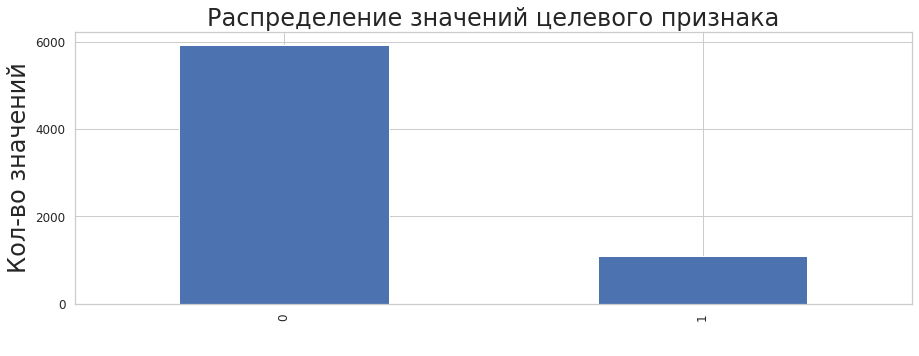

In [ ]:
plt.figure(figsize=(15, 5))
df['target'].value_counts().plot(
    kind='bar',
    title='Распределение значений целевого признака',
    fontsize=12
).set(xlabel=' ', ylabel='Кол-во значений')
plt.show()

Наблюдается дисбаланс классов, но, так как наша ключевая метрика auc-roc нечуствительна к дисбалансу, мы не будем использовать методы балансировки.

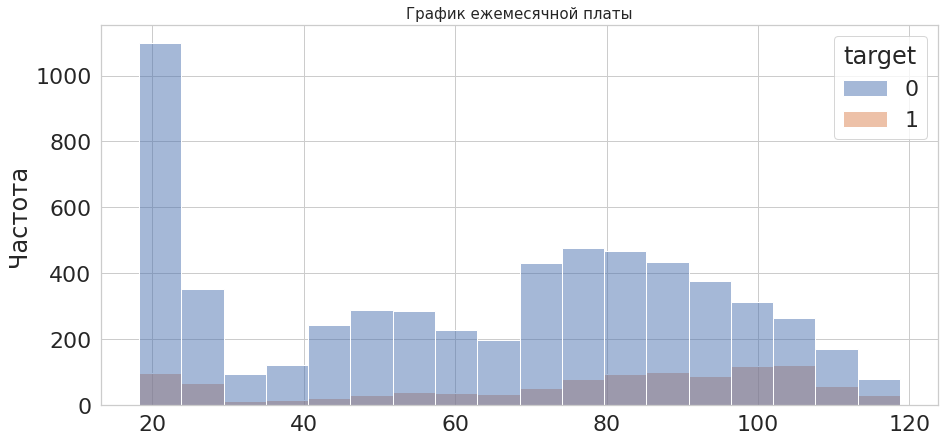

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot( x='monthly_charges', data=df, hue='target').set_title(
    label ='График ежемесячной платы',
    size=15)
plt.xlabel(None)
plt.ylabel('Частота');
plt.show()

По графику заметно, что существенная часть ушедших клиентов ежемесячно платила от 70 до 110 у.е, это довольно большие суммы, на фоне общего распределения. Данные оставшихся клиентов разбиты неравномерно, многие подключают минимально стоящие услуги, так же существенная часть платит от 70 до 100 у.е.

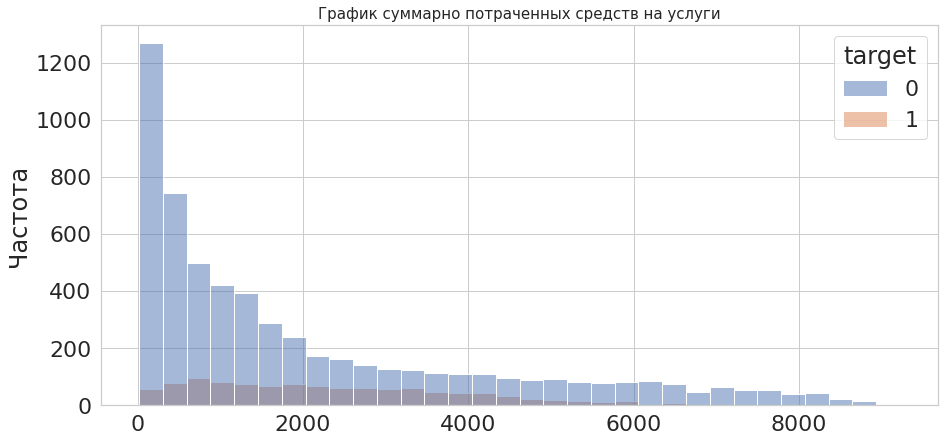

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot( x='total_charges', data=df, hue='target').set_title(
    label ='График суммарно потраченных средств на услуги',
    size=15)
plt.xlabel(None)
plt.ylabel('Частота');
plt.show()

Заметно нормальное распределение данных. Почти отсутствуют ушедшие пользователи, поратившие суммарно больше 6000.

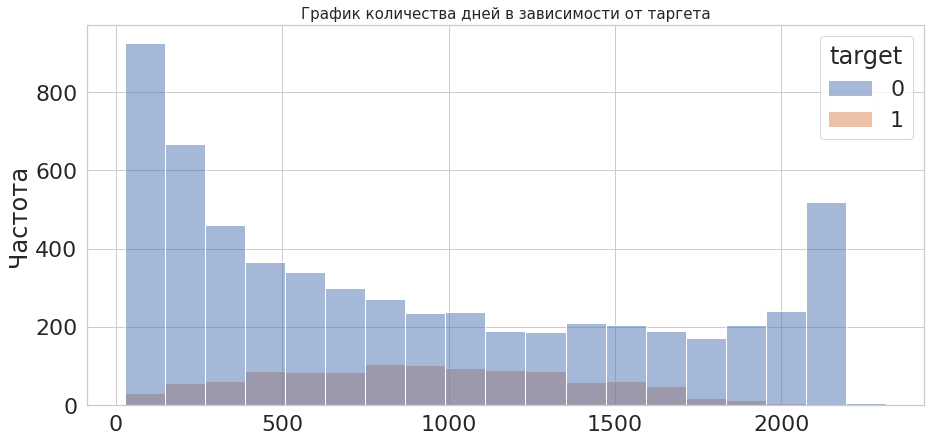

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot( x='days', data=df, hue='target').set_title(
    label ='График количества дней в зависимости от таргета',
    size=15)
plt.xlabel(None)
plt.ylabel('Частота')
plt.show()

Оставшиеся клиенты - это, в основном, либо недавно подключенные пользователи, либо наоборот, очень старые абоненты. Заметен отток 'средних' клиентов. Большая чась ушедших клиентов пользовалась услугами от от 500 до 1500 дней.

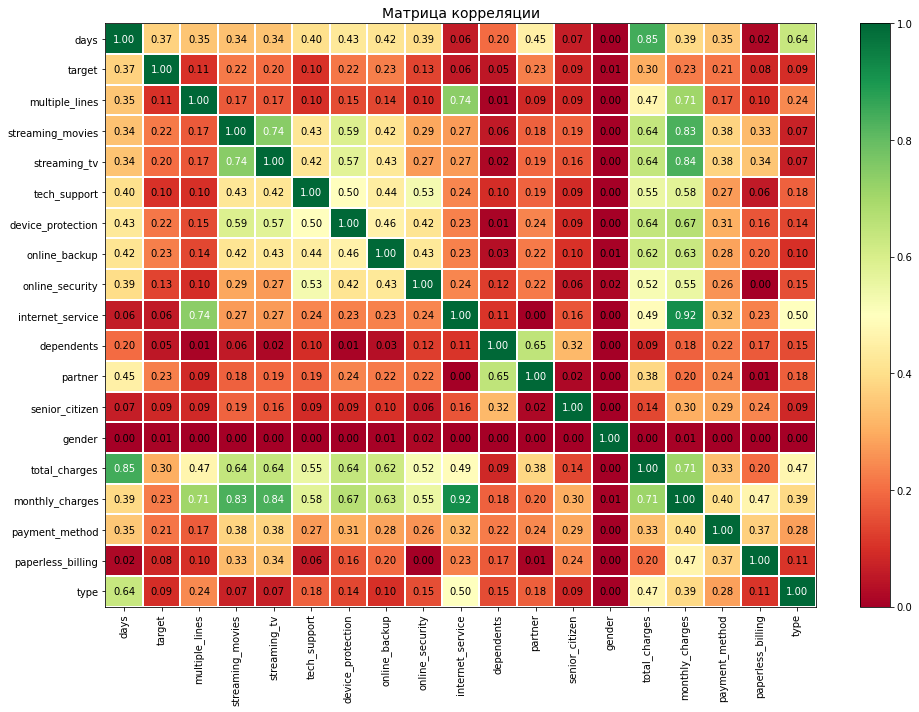

In [ ]:
interval_cols = ['monthly_charges', 'total_charges', 'days']
phik_matrix = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_matrix.values,
                       x_labels=phik_matrix.columns,
                       y_labels=phik_matrix.index,
                       vmin=0, vmax=1,
                       figsize=(14, 10),
                       title='Матрица корреляции')
plt.tight_layout();

Ни один из признаков не оказывает существенного влияния на целевой признак. Наблюдается зависимость между интернет услугами и ежемсячыным платежем, а так же общей суммой потраченных среств. Особенно выделяется корреляция между monthly charges и internet service - 0.92, видимо, на фоне остальных услуг интернет является самым дорогим.

In [ ]:
df[interval_cols].corr()

,monthly_charges,total_charges,days
monthly_charges,1.000000,0.630297,0.218955
total_charges,0.630297,1.000000,0.821442
days,0.218955,0.821442,1.000000


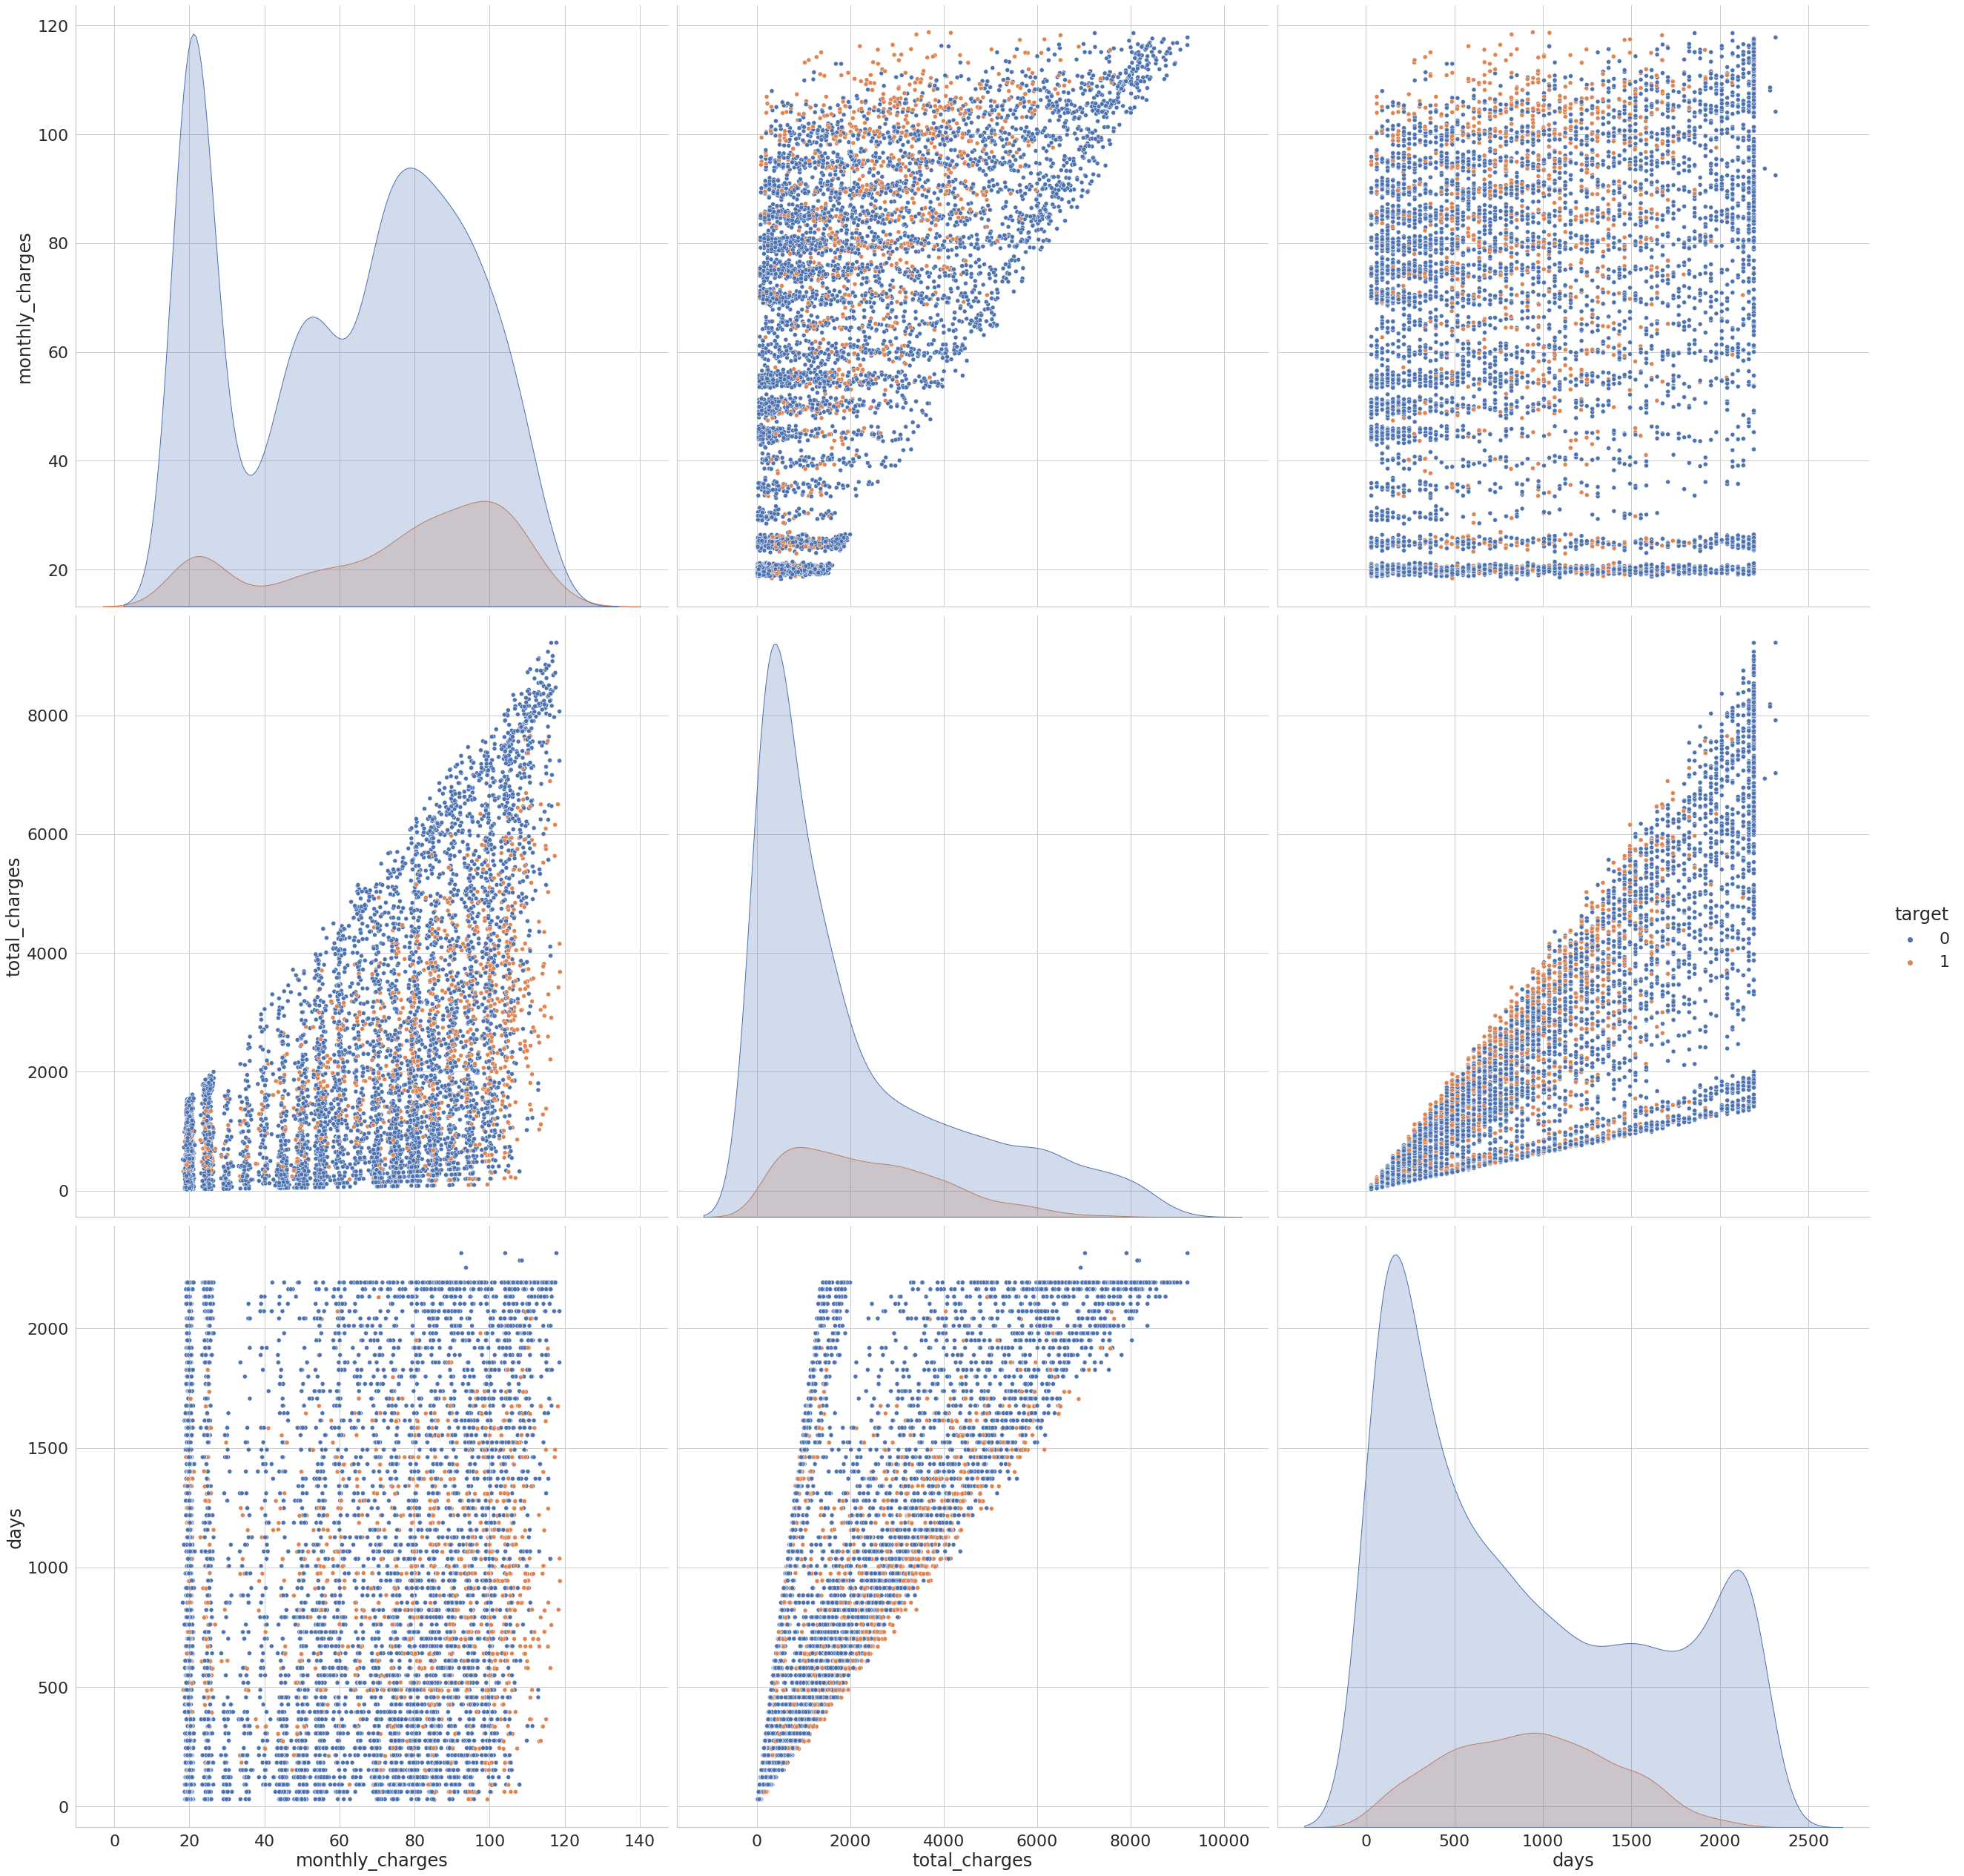

In [ ]:
sns.pairplot(df[['monthly_charges', 'total_charges', 'target', 'days']], hue='target', height=12);

Сильная зависимость между общей суммой платежей и количеством дней пользования услугами - не удивительно, ведь чем больше дней пользования, тем и больше суммарно потраченных средств. Можно заметить, что основная доля ушедших клиентов пользовалась от 500 до 1500 дней и потратила от 2000 до 6000 у.е суммарно.

Так же наблюдается умеренная зависимость между ежемесячным платежем и общей суммой, коэф.корреляции - 0.63. Заметно, что большая часть ушедших клиентов платила ежемесячно от 80у.е и выше, в то время как распределение оставшихся клиентов равномерно.

Между monthly_changes и days наблюдается слабая степень корреляции - 0.22.

## Обучение моделей

### Деление на выборки

In [ ]:
features = df.drop('target', axis=1)
target = df['target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=RANDOM_STATE)


In [ ]:
features_oe = df.drop('target', axis=1)
target_oe = df['target']

features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, target_oe, test_size=0.25,
                                                                            random_state=RANDOM_STATE)


In [ ]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
                'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [ ]:
#var_categorical = ['type', 'payment_method', 'gender', 'internet_service', 'multiple_lines']

ordinal_encoder = OrdinalEncoder()

features_train_oe[cat_features] = ordinal_encoder.fit_transform(features_train_oe[cat_features])
features_test_oe[cat_features] = ordinal_encoder.transform(features_test_oe[cat_features])

In [ ]:
display(features_train_oe)
features_train_oe.shape

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
customerID,,,,,,,,,,,,,,,,,,
5954-BDFSG,2.0,1.0,1.0,107.50,7740.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2191
6419-ZTTLE,1.0,1.0,2.0,20.75,496.34,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,702
4818-DRBQT,0.0,1.0,0.0,80.15,2644.95,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1006
8242-JSVBO,0.0,1.0,0.0,44.65,312.55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,215
4664-NJCMS,2.0,0.0,0.0,59.55,1965.15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469-QJKZW,0.0,0.0,2.0,20.15,80.60,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,123
6981-TDRFT,1.0,1.0,2.0,54.30,2389.20,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1340
9330-IJWIO,0.0,1.0,2.0,100.35,1717.99,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,488


(5274, 18)

### Decision Tree  

In [ ]:
pipeline = Pipeline([('dt', RandomForestClassifier(random_state=RANDOM_STATE, verbose=False))])
param = {'dt__min_samples_split' : range(5, 10, 1),
        'dt__max_depth' : range(6, 19, 2),
        'dt__min_samples_leaf' : range(20, 51, 10)
}

In [ ]:
model_dt = GridSearchCV(estimator=pipeline,
                       param_grid=param,
                       scoring='roc_auc',
                       cv=4)
model_dt.fit(features_train_oe, target_train_oe)
display(model_dt.best_params_)
display(model_dt.best_score_)

{'dt__max_depth': 12, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 5}

0.8256511806239545

### Random Forest

In [ ]:
pipeline = Pipeline([('rf', RandomForestClassifier(random_state=RANDOM_STATE, verbose=False))])
param = {'rf__min_samples_split' : range(3, 8, 2),
        'rf__max_depth' : range(4, 13, 2),
        'rf__n_estimators' : [100, 300]
}

In [ ]:
model_rf = GridSearchCV(estimator=pipeline,
                       param_grid=param,
                       scoring='roc_auc',
                       cv=4)
model_rf.fit(features_train_oe, target_train_oe)
display(model_rf.best_params_)
display(model_rf.best_score_)

{'rf__max_depth': 8, 'rf__min_samples_split': 7, 'rf__n_estimators': 300}

0.8299039618065336

### CatBoost

In [ ]:
pipeline = Pipeline([('cb', CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_features,
                                               loss_function='CrossEntropy', verbose=False))])
param = {'cb__learning_rate' : np.arange(0.1, 0.31, 0.05),
        'cb__depth' : range(3, 9, 1),
        #'cb__loss_function' : ['CrossEntropy', 'logloss'],
        'cb__iterations' : [1000]}

In [ ]:
model_cb = GridSearchCV(estimator=pipeline,
                       param_grid=param,
                       scoring='roc_auc',
                       cv=4)
model_cb.fit(features_train, target_train)
display(model_cb.best_params_)
display(model_cb.best_score_)

{'cb__depth': 3,
 'cb__iterations': 1000,
 'cb__learning_rate': 0.20000000000000004}

0.9168500932973683

Наиболее эффективной моделью на данном этапе является CatBoost со значение auc-roc = 0.917 и гиперпараметрами depth = 3, iterations = 1000, learning rate = 0.2. Продолжим работу с этой моделью на финальном тестировании.

DecisionTree и RandomForest показали результаты равные 0.825 и 0.83 соответственно.

## Тестирование модели

### Анализ модели

In [ ]:
predicted_prob = roc_auc_score(target_test, model_cb.best_estimator_.predict_proba(features_test)[:, 1])
print(f'ROC-AUC: {predicted_prob:.3f}')
print(f'Accuracy: {accuracy_score(target_test, model_cb.predict(features_test)):.3f}')

ROC-AUC: 0.927
Accuracy: 0.939


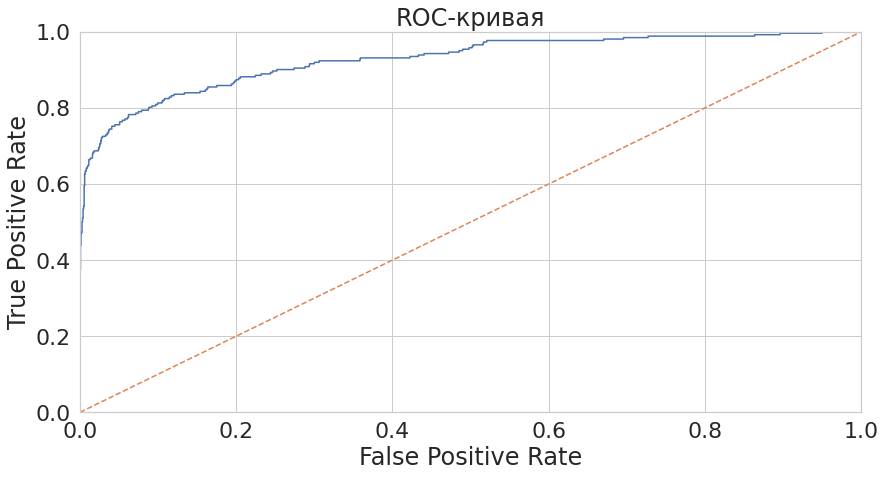

In [ ]:
predicted_probalities = model_cb.best_estimator_.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)

plt.figure(figsize=(14, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

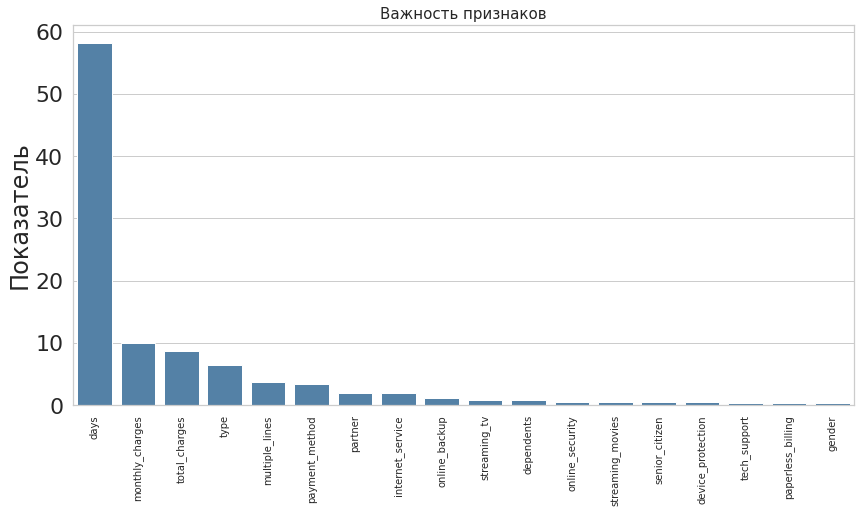

In [ ]:
features_importances = pd.DataFrame(data={'features': features_train.columns,
          'importance':model_cb.best_estimator_._final_estimator.feature_importances_
      }).sort_values(by='importance', ascending=False)
plt.figure(figsize=(14,7))
sns.barplot(x=features_importances['features'], y=features_importances['importance'], color='steelblue')
plt.title('Важность признаков', size=15)
plt.xlabel('')
plt.ylabel('Показатель')
plt.xticks(rotation='vertical', size=10)
plt.show();

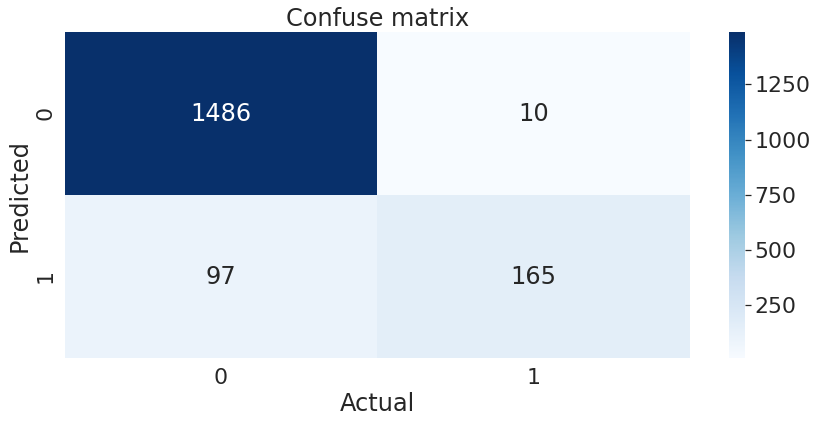

In [ ]:
confuse_matrix = pd.DataFrame(confusion_matrix(target_test, model_cb.best_estimator_.predict(features_test)))
plt.figure(figsize=(14, 6))
sns.heatmap(confuse_matrix,
                annot=True,
                cmap='Blues',
                fmt='d')
plt.title('Confuse matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show();

### Вывод

После финального тестирования модели можно сделать следующие выводы:

1. Для тестирования была выбрана модель CatBoost с гиперпараметрами: depth = 3, iterations = 1000, learning rate = 0.2, loss function - CrossEntropy. Были достигнуты высокие показатели AUC-ROC = 0.927, accuracy = 0.939
2. Наиболее важные факторы для данной модели - количество дней пользования клиентом услугами компании, общая сумма потраченных средств и сумма ежемесячного платежа.
3. Судя по матрице ошибок, модель верно предсказывает True Positive и True Negativ, при этом допускает минимальное количество False Positive и изредка выдает False Negative прогнозы. То есть модель, за редким исключением, верно интерпретирует клиентов, которые планируют уходить.

## Отчет по исследованию

1. Какие пункты плана были выполнены, а какие — нет. Почему?

В ходе работы все поставленные пункты плана были выполнены:

- Изучили техническое задание, провели первичный анализ

- Была выполнена предобработка данных, был проведен исследовательский анализ - рассмотрены все признаки и их влияние на целевую переменную, сделан корреляционнный анализ при помощи библиотеки phik.

- Данные были разбиты на тренировочную и тестовую выборки, после чего выборки были закодированы и на них обучнились три модели, для которых были подобраны соответствующие гиперпарметры. При обучении были задействованы pipline и GridSearch.

- Получили финальные результаты на тестовой выборке, оценили важность признаков, построили rog-кривую и матрицу ошибок.

2. Какие трудности возникли и как вы их преодолели?

В первые дни спринта возникали некоторые проблемы с пониманием того, какими методами лучше воспользоваться. Вебинар внес ясность и стало намного проще. Например, такие подсказки, что лучше в исследовательском анализе использовать phik, pairplot, а для тестирования построить features importance и confuse matrix. А так же, важная информация, что не надо бороться с дисбалансом, так как метрика auc-roc нечуствительна к нему.

3. Какие ключевые шаги в решении задачи вы выделили?

Главное - последовательное выполнение каждого шага работы. Ключевым же шагом является постановка задачи и планирование, какими методами мы будем достигать поставленной задачи.

4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Все признаки, так или иначе, были задействованы. Для DecisionTree и RandomForest провели кодировку признаков через Ordinal Encoder, для CatBoost использовали внутренний кодировщик. Из удаленных begin_date и end_date был создан дополнительный признак - количство дней, из end_date так же был выявлен целевой признак. Был создан единый датасет, поделили бинарные признаки на 1 и 0 и привели данные к корректному формату. Заполнили пропуски, которые появились после объединения датасета.

5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

CatBoost с гиперпараметрами: depth = 3, iterations = 1000, learning rate = 0.2, loss function - CrossEntropy. AUC-ROC - 0.927, Accuracy - 0.939